# Season simulator

## Set-up

In [1]:
import json
import requests
import getpass
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from s3fs import S3FileSystem
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.metrics import mean_squared_error

In [2]:
os.chdir('../..')

In [3]:
from src.data.s3_utilities import s3_filesystem
from src.models.LSTM.make_predictions import load_retro_data

Using TensorFlow backend.


In [4]:
pd.options.display.max_columns = None

## 1. Backfill retro predictions for 2019-20 season

In [11]:
double_gws = {
    24: ['West Ham United', 'Liverpool'],
    30: ['Aston Villa', 'Manchester City', 'Sheffield United', 'Arsenal']
}

__GW 1__

In [12]:
payload = {
    "previous_gw": 38,
    "prediction_season_order": 3,
    "live_run": False,
}

In [14]:
response = requests.get("http://0.0.0.0:5000/api", json=payload)
response

<Response [200]>

In [6]:
# Note: To get correct format of data argument for curl
response.request.body

b'{"previous_gw": 38, "prediction_season_order": 3, "live_run": false}'

__GWs 2-36__

In [7]:
[i - 1 for i in double_gws.keys()]

[23, 29]

In [8]:
%%time
for prev_gw in range(1, 37):
    print(f'Previous GW: {prev_gw}')
    if prev_gw in [i - 1 for i in double_gws.keys()]:
        double_gw_teams = double_gws[prev_gw + 1]
        print(f'GW {prev_gw + 1} is a double GW')
    else:
        double_gw_teams = []
    
    if prev_gw in double_gws.keys():
        previous_gw_was_double_gw = True
        print('Previous GW was a double GW')
    else:
        previous_gw_was_double_gw = False
    
    payload = {
        "previous_gw": prev_gw,
        "prediction_season_order": 4,
        "live_run": False,
        "double_gw_teams": double_gw_teams,
        "previous_gw_was_double_gw": previous_gw_was_double_gw
    }
    
    response = requests.get("http://0.0.0.0:5000/api", json=payload)
    assert response.status_code == 200

Previous GW: 1
Previous GW: 2
Previous GW: 3
Previous GW: 4
Previous GW: 5
Previous GW: 6
Previous GW: 7
Previous GW: 8
Previous GW: 9
Previous GW: 10
Previous GW: 11
Previous GW: 12
Previous GW: 13
Previous GW: 14
Previous GW: 15
Previous GW: 16
Previous GW: 17
Previous GW: 18
Previous GW: 19
Previous GW: 20
Previous GW: 21
Previous GW: 22
Previous GW: 23
GW 24 is a double GW
Previous GW: 24
Previous GW was a double GW
Previous GW: 25
Previous GW: 26
Previous GW: 27
Previous GW: 28
Previous GW: 29
GW 30 is a double GW
Previous GW: 30
Previous GW was a double GW
Previous GW: 31
Previous GW: 32
Previous GW: 33
Previous GW: 34
Previous GW: 35
Previous GW: 36
CPU times: user 108 ms, sys: 20.6 ms, total: 128 ms
Wall time: 1min 41s


### Check predictions

In [55]:
S3_BUCKET_PATH = "s3://fpl-analysis-data"

GW_RETRO_PREDICTIONS_SUFFIX = "/gw_retro_predictions"

In [6]:
season_predictions = pq.read_table(
    S3_BUCKET_PATH+GW_RETRO_PREDICTIONS_SUFFIX+'/season=2019-20',
    filesystem=s3_filesystem
).to_pandas()

In [7]:
season_predictions.shape

(20777, 15)

In [9]:
season_predictions.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,next_match_value,model,gw
0,6.351485,6.109851,6.123810,6.017258,6.038771,30.641174,mohamed_salah,0,0,0,1,Liverpool,12.5,lstm_v4,1
1,5.527633,5.313435,5.318930,5.216153,5.230146,26.606297,sadio_mané,0,0,0,1,Liverpool,11.5,lstm_v4,1
2,5.272620,5.067393,5.070838,4.969124,4.981099,25.361074,sergio_agüero,0,1,0,0,Manchester City,12.0,lstm_v4,1
3,4.748150,4.563293,4.563362,4.464828,4.472931,22.812565,raheem_sterling,0,0,0,1,Manchester City,12.0,lstm_v4,1
4,4.482633,4.303859,4.299732,4.201766,4.206832,21.494823,trent_alexander-arnold,1,0,0,0,Liverpool,7.0,lstm_v4,1


In [8]:
season_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20777 entries, 0 to 20776
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GW_plus_1         20583 non-null  float32 
 1   GW_plus_2         20583 non-null  float32 
 2   GW_plus_3         20583 non-null  float32 
 3   GW_plus_4         20583 non-null  float32 
 4   GW_plus_5         20583 non-null  float32 
 5   sum               20583 non-null  float32 
 6   name              20777 non-null  object  
 7   position_DEF      20777 non-null  uint8   
 8   position_FWD      20777 non-null  uint8   
 9   position_GK       20777 non-null  uint8   
 10  position_MID      20777 non-null  uint8   
 11  team_name         20777 non-null  object  
 12  next_match_value  20583 non-null  float64 
 13  model             20777 non-null  object  
 14  gw                20777 non-null  category
dtypes: category(1), float32(6), float64(1), object(3), uint8(4)
memory usa

In [9]:
season_predictions['gw'] = season_predictions['gw'].astype(int)

In [10]:
season_predictions[season_predictions['sum'].isnull()].head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,next_match_value,model,gw
420,NaN,NaN,NaN,NaN,NaN,NaN,aaron_ramsey,0,0,0,1,Arsenal,NaN,lstm_v4,1
421,NaN,NaN,NaN,NaN,NaN,NaN,aaron_rowe,0,0,0,1,Huddersfield Town,NaN,lstm_v4,1
422,NaN,NaN,NaN,NaN,NaN,NaN,abdelhamid_sabiri,0,0,0,1,Huddersfield Town,NaN,lstm_v4,1
423,NaN,NaN,NaN,NaN,NaN,NaN,aboubakar_kamara,0,1,0,0,Fulham,NaN,lstm_v4,1
424,NaN,NaN,NaN,NaN,NaN,NaN,adama_diakhaby,0,0,0,1,Huddersfield Town,NaN,lstm_v4,1


In [11]:
season_predictions[season_predictions['sum'].isnull()]['gw'].unique()

array([1])

__Observations:__

- GW 1 null predictions caused by players who left at the end of the previous season e.g. Rambo who left after the 2018-19 season
- No null predictions in GWs 18 and 28 where there were less than 10 fixtures (9 and 8 respectively)
- This is a problem which occurs with live runs but not retro runs because it uses the fixture data from the gw after next
- Either remove these predictions manually or do an inner join on gw, name when joining to actuals
- Note: fpl-team-selector explicitly handles these cases so may be worth dropping instead

In [12]:
# Drop GW 1 null predictions caused by departing players

season_predictions['drop_row'] = np.where(
    (season_predictions['gw'] == 1) & (season_predictions['sum'].isnull()),
    1,
    0
)

season_predictions = season_predictions[season_predictions['drop_row'] == 0]
season_predictions.drop('drop_row', axis=1, inplace=True)

Check that new players only had predictions after 5 GWs had passed

In [13]:
season_predictions[season_predictions['name'] == 'jack_grealish'].sort_values('gw').head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,next_match_value,model,gw
18706,2.878082,2.756484,2.739711,2.649722,2.641908,13.665906,jack_grealish,0,0,0,1,Aston Villa,5.9,lstm_v4,6
19216,3.043094,2.915220,2.899431,2.808566,2.801941,14.468250,jack_grealish,0,0,0,1,Aston Villa,5.9,lstm_v4,7
19760,2.948712,2.824652,2.808378,2.718143,2.710889,14.010775,jack_grealish,0,0,0,1,Aston Villa,5.9,lstm_v4,8
20287,3.075595,2.946852,2.931522,2.840578,2.834301,14.628847,jack_grealish,0,0,0,1,Aston Villa,5.9,lstm_v4,9
634,3.670371,3.519083,3.507510,3.413307,3.411342,17.521614,jack_grealish,0,0,0,1,Aston Villa,5.9,lstm_v4,10


### Measure MSE over season

In [14]:
actuals = pd.read_parquet('data/gw_player_data/gw_37_player_data.parquet')
print(actuals.shape)
actuals.head()

(21836, 52)


,total_points,was_home,team_h_score,team_a_score,gw,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,kickoff_month_Jan,kickoff_month_Jul,kickoff_month_Jun,kickoff_month_Mar,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,ID
0,0,False,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,592
1,0,True,2,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,592
2,0,False,3,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,592
3,0,True,2,2,4,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,592
4,0,False,2,2,5,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,592


In [15]:
actuals = actuals[['name', 'gw', 'total_points']]

In [16]:
comparision_df = season_predictions.merge(actuals, on=['name', 'gw'], how='inner')

In [17]:
comparision_df.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,next_match_value,model,gw,total_points
0,6.351485,6.109851,6.123810,6.017258,6.038771,30.641174,mohamed_salah,0,0,0,1,Liverpool,12.5,lstm_v4,1,12
1,5.527633,5.313435,5.318930,5.216153,5.230146,26.606297,sadio_mané,0,0,0,1,Liverpool,11.5,lstm_v4,1,1
2,5.272620,5.067393,5.070838,4.969124,4.981099,25.361074,sergio_agüero,0,1,0,0,Manchester City,12.0,lstm_v4,1,5
3,4.748150,4.563293,4.563362,4.464828,4.472931,22.812565,raheem_sterling,0,0,0,1,Manchester City,12.0,lstm_v4,1,20
4,4.482633,4.303859,4.299732,4.201766,4.206832,21.494823,trent_alexander-arnold,1,0,0,0,Liverpool,7.0,lstm_v4,1,5


In [18]:
comparision_df.sort_values(['name', 'gw'], inplace=True)

In [19]:
for i in range(2, 6):
    comparision_df[f'GW_plus_{i}_actuals'] = comparision_df.groupby('name')['total_points'].shift(-(i-1))

In [20]:
comparision_df.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,next_match_value,model,gw,total_points,GW_plus_2_actuals,GW_plus_3_actuals,GW_plus_4_actuals,GW_plus_5_actuals
15037,2.077689,2.003415,2.018901,1.961140,1.971908,10.033052,aaron_connolly,0,1,0,0,Brighton & Hove Albion,4.5,lstm_v4,9,1,8.0,2.0,1.0,0.0
542,2.386304,2.291364,2.288405,2.213917,2.213574,11.393564,aaron_connolly,0,1,0,0,Brighton & Hove Albion,4.6,lstm_v4,10,8,2.0,1.0,0.0,2.0
1067,2.440585,2.339514,2.327609,2.245897,2.239845,11.593451,aaron_connolly,0,1,0,0,Brighton & Hove Albion,4.6,lstm_v4,11,2,1.0,0.0,2.0,2.0
1607,2.511574,2.405174,2.388385,2.302404,2.293423,11.900960,aaron_connolly,0,1,0,0,Brighton & Hove Albion,4.7,lstm_v4,12,1,0.0,2.0,2.0,0.0
2190,2.271276,2.176594,2.162898,2.081366,2.073513,10.765648,aaron_connolly,0,1,0,0,Brighton & Hove Albion,4.7,lstm_v4,13,0,2.0,2.0,0.0,0.0


In [21]:
comparision_df.rename(columns={'total_points': 'GW_plus_1_actuals'}, inplace=True)

In [22]:
for gw in range(1, 6):
    temp = comparision_df.copy()
    temp.dropna(subset=[f'GW_plus_{gw}_actuals'], inplace=True)
    
    mse = mean_squared_error(temp[f'GW_plus_{gw}_actuals'], temp[f'GW_plus_{gw}'])
    
    print(f'MSE GW_plus_{gw}: {mse}')

MSE GW_plus_1: 4.784461402419001
MSE GW_plus_2: 4.91152107129014
MSE GW_plus_3: 5.107444619702865
MSE GW_plus_4: 5.245304917428603
MSE GW_plus_5: 5.291551477004224


## 2. Simulate team selection over season

__Load retro data so budgets can be calculated over time__

In [5]:
retro_data = load_retro_data(current_season_data_filepath='data/gw_player_data/gw_37_player_data.parquet')
retro_data.head()

2020-08-27 01:27:37,635 - Loading raw historical FPL data
2020-08-27 01:27:37,714 - Loaded historical data of shape: (67797, 52)
2020-08-27 01:27:37,806 - Creating season order column
2020-08-27 01:27:37,916 - Generating known features for next GW
2020-08-27 01:27:38,239 - Final input shape: (89633, 68)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,1,0,0.1,1,0,0.0,0.2,24,0,0,0,0,4,0,0,0,4,0.0,1,0,0,0,4.5,False,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,4,4.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0,0.3,1,0,2.2,1.0,6,0,0,0,0,5,0,14029,1,1,21.0,1,10589,13500,2911,4.5,True,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Burnley,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,4.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,1,0,4.8,0,0,2.5,2.0,20,0,0,0,0,6,0,22804,0,0,18.0,1,8090,11749,3659,4.5,False,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Newcastle United,0,0,1,0,0,1,0,0,0,0,0,0,0,0,4,4.5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,2,0,0.6,1,0,0.1,0.2,25,0,0,0,0,7,0,32699,0,2,0.0,1,8437,13439,5002,4.5,False,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Chelsea,0,1,0,0,0,1,0,0,0,0,0,0,0,0,4,4.5,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,3,53,1,23.8,0,2,20.1,70.2,79,0,0,0,0,8,0,35026,0,3,107.0,13,2156,5952,3796,4.5,True,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Tottenham Hotspur,0,1,0,1,0,0,1,0,0,0,0,0,0,0,4,4.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
retro_data['name'] = retro_data['name'].str.replace(' ', '_')
retro_data['name'] = retro_data['name'].str.replace('-', '_')

__GW 1__

In [7]:
payload = {
    "previous_gw": 38,
    "season": '2018-19',
    "previous_team_selection_path": '',
    "budget": 100.,
    "available_chips": ['new_team'],
    "available_transfers": 15,
    "save_selection": True,
    "player_overwrites": {
        'marko_arnautovic': 0  # Off to China soon
    },
    "team_prediction_scalars": {}
}

In [8]:
response = requests.get("http://0.0.0.0:5000/retro", json=payload)
response

<Response [200]>

In [9]:
gw1_team = pq.read_table(
    's3://fpl-analysis-data/gw_team_selections/season=2019-20/gw=1',
    filesystem=s3_filesystem
).to_pandas()

gw1_team

,name,position_DEF,position_MID,position_FWD,position_GK,team_name,in_starting_11,is_captain,is_vice_captain,bench_order,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,predictions,now_cost,purchase_price,gw_introduced_in,in_current_team
0,mohamed_salah,0,1,0,0,Liverpool,1.0,1,0,-1.0,6.351485,6.109851,6.123810,6.017258,6.038771,30.641174,12.5,12.5,1,0
1,trent_alexander_arnold,1,0,0,0,Liverpool,1.0,0,1,-1.0,4.482633,4.303859,4.299732,4.201766,4.206832,21.494823,7.0,7.0,1,0
2,ryan_fraser,0,1,0,0,Bournemouth,1.0,0,0,-1.0,4.405811,4.228928,4.224128,4.126262,4.130728,21.115858,7.5,7.5,1,0
3,bernardo_mota_veiga_de_carvalho_e_silva,0,1,0,0,Manchester City,1.0,0,0,-1.0,4.145993,3.980486,3.974735,3.878572,3.881425,19.861210,8.0,8.0,1,0
4,andrew_robertson,1,0,0,0,Liverpool,1.0,0,0,-1.0,4.102501,3.939468,3.933663,3.838172,3.840784,19.654587,7.0,7.0,1,0
5,aymeric_laporte,1,0,0,0,Manchester City,1.0,0,0,-1.0,3.625871,3.478546,3.467962,3.374437,3.372796,17.319613,6.5,6.5,1,0
6,raúl_jiménez,0,0,1,0,Wolverhampton Wanderers,1.0,0,0,-1.0,3.504322,3.360747,3.349149,3.256065,3.253362,16.723646,7.5,7.5,1,0
7,lucas_digne,1,0,0,0,Everton,1.0,0,0,-1.0,3.425095,3.283260,3.270407,3.177402,3.173896,16.330059,6.0,6.0,1,0
8,diogo_jota,0,0,1,0,Wolverhampton Wanderers,1.0,0,0,-1.0,3.221824,3.086373,3.071676,2.979309,2.974025,15.333206,6.5,6.5,1,0
9,gerard_deulofeu,0,0,1,0,Watford,1.0,0,0,-1.0,3.199513,3.067007,3.052963,2.961675,2.956536,15.237694,6.5,6.5,1,0


In [10]:
team_cost = gw1_team['purchase_price'].sum()
team_cost

100.0

In [11]:
MONEY_IN_BANK = 100
MONEY_IN_BANK -= team_cost

__GW 2-36__

In [12]:
def calculate_next_gw_budget(selected_team, team_gameweek, team_season, money_in_bank, price_df=retro_data):
    # Get purchase prices for next gameweek
    current_prices_df = price_df[
        (price_df['gw'] == team_gameweek + 1) & 
        (price_df['season'] == team_season)
    ][['name', 'value']]

    current_prices_df.rename(columns={'value': 'next_match_value'}, inplace=True)

    budget_components = get_budget_components(selected_team, current_prices_df)
    
    budget = budget_components['selling_price'].sum()
    budget += money_in_bank
    budget = np.round(budget, decimals=1)

    return budget

In [13]:
SELL_ON_TAX = 0.5

def round_down_to_nearest_10th(num):
    """
    Round number down to nearest 10th
    :param num: Number
    :return: Number rounded down to nearest 10th
    """
    return np.floor(num*10) / 10

def get_budget_components(previous_team_selection, current_predictions_df):
    """
    Get available budget. Factors in tax on any sales profits made. See
    https://twitter.com/officialfpl/status/810473725627957248?lang=en;
    https://www.reddit.com/r/FantasyPL/comments/90pgwq/can_someone_explain_to_me_how_price_change_works/
    for details.

    :param previous_team_selection: DataFrame of players selected in previous GW containing 'purchase_price' column.
    :param current_predictions_df: DataFrame of current predictions containing 'next_match_value' column.
    :param money_in_bank: Money in FPL bank
    :return: Budget
    """
    budget_calculation_df = previous_team_selection[['name', 'purchase_price']].merge(
        current_predictions_df[['name', 'next_match_value']],
        how='left',
        on='name'
    )
    budget_calculation_df.rename(columns={'next_match_value': 'current_price'}, inplace=True)

    budget_calculation_df['profit'] = budget_calculation_df['current_price'] - budget_calculation_df['purchase_price']
    budget_calculation_df['profit'] = np.round(budget_calculation_df['profit'], 2)  # To prevent Python precision errors
    budget_calculation_df['profit_after_tax'] = (budget_calculation_df['profit'] * SELL_ON_TAX).apply(
        round_down_to_nearest_10th
    )

    budget_calculation_df['selling_price'] = np.where(
        budget_calculation_df['profit'] > 0,
        budget_calculation_df['purchase_price'] + budget_calculation_df['profit_after_tax'],
        budget_calculation_df['current_price']
    )

#     budget = budget_calculation_df['selling_price'].sum()
#     budget += money_in_bank
#     budget = np.round(budget, decimals=1)

    return budget_calculation_df

In [14]:
MONEY_IN_BANK

0.0

In [15]:
AVAILABLE_CHIPS = ['wildcard', 'freehit']

In [16]:
AVAILABLE_TRANSFERS = 0

In [17]:
for previous_gw in range (1, 20):
    print(f'Team selection for GW {previous_gw + 1}')
    
    if AVAILABLE_TRANSFERS < 2:
        AVAILABLE_TRANSFERS += 1
    print('Available transfers:', AVAILABLE_TRANSFERS)
    
    if previous_gw <= 4:
        available_chips = []
    else:
        available_chips = AVAILABLE_CHIPS
    print('Available chips:', available_chips)
    
    # Get previous gameweek team selection
    previous_team_selection = pq.read_table(
        f's3://fpl-analysis-data/gw_team_selections/season=2019-20/gw={previous_gw}',
        filesystem=s3_filesystem
    ).to_pandas()

    # Get budget for next gameweek
    next_gw_budget = calculate_next_gw_budget(previous_team_selection, previous_gw, '2019-20', MONEY_IN_BANK, retro_data)

    # Select team
    payload = {
        "previous_gw": previous_gw,
        "season": '2019-20',
        "previous_team_selection_path": f's3://fpl-analysis-data/gw_team_selections/season=2019-20/gw={previous_gw}',
        "budget": next_gw_budget,
        "available_chips": available_chips,
        "available_transfers": AVAILABLE_TRANSFERS,
        "save_selection": True,
        "player_overwrites": {},
        "team_prediction_scalars": {}
    }

    response = requests.get("http://0.0.0.0:5000/retro", json=payload)
    print(response)
    
    best_permutation = max(
        response.json(),
        key=lambda k: response.json()[k]['total_points']
    )

    if best_permutation in AVAILABLE_CHIPS:
        AVAILABLE_CHIPS.remove(best_permutation)

    time.sleep(5)

    # Update money in bank

    ## Load next team
    next_team_selection = pq.read_table(
        f's3://fpl-analysis-data/gw_team_selections/season=2019-20/gw={previous_gw+1}',
        filesystem=s3_filesystem
    ).to_pandas()

    transfers_in = set(next_team_selection['name']) - set(previous_team_selection['name'])
    print('In:', transfers_in)
    transfers_out = set(previous_team_selection['name']) - set(next_team_selection['name'])
    print('Out:', transfers_out)
    
    num_transfers = len(transfers_in)
    print(f'Number of transfers: {num_transfers}')
    
    # Update available transfers
    AVAILABLE_TRANSFERS = max(0, AVAILABLE_TRANSFERS - num_transfers)    

    ## Get selling prices of transfers out from previous team
    previous_team_selection_with_selling_price = get_budget_components(
        previous_team_selection, 
        current_predictions_df=retro_data[  # Prices of players in next gameweek (need to calculate profit on sale)
            (retro_data['gw'] == previous_gw + 1) & 
            (retro_data['season'] == '2019-20')
        ][['name', 'value']].rename(
            columns={
                'value': 'next_match_value'
            }
        )
    )

    value_of_sales = previous_team_selection_with_selling_price.loc[previous_team_selection_with_selling_price['name'].isin(transfers_out)]['selling_price'].sum()
    print(f'Value of sales: {value_of_sales}')

    value_of_purchases = next_team_selection.loc[next_team_selection['name'].isin(transfers_in)]['purchase_price'].sum()
    print(f'Value of purchases: {value_of_purchases}')

    MONEY_IN_BANK -= np.round(value_of_purchases - value_of_sales, 1)
    print(f'Money in bank {MONEY_IN_BANK}')

Team selection for GW 2
Available transfers: 1
Available chips: []
<Response [200]>
In: {'ashley_barnes'}
Out: {'gerard_deulofeu'}
Number of transfers: 1
Value of sales: 6.5
Value of purchases: 6.5
Money in bank 0.0
Team selection for GW 3
Available transfers: 1
Available chips: []
<Response [200]>
In: {'leander_dendoncker'}
Out: {'mark_noble'}
Number of transfers: 1
Value of sales: 5.0
Value of purchases: 4.5
Money in bank 0.5
Team selection for GW 4
Available transfers: 1
Available chips: []
<Response [200]>
In: {'moussa_sissoko'}
Out: {'ilkay_gündogan'}
Number of transfers: 1
Value of sales: 5.4
Value of purchases: 5.0
Money in bank 0.9
Team selection for GW 5
Available transfers: 1
Available chips: []
<Response [200]>
In: {'kevin_de_bruyne', 'martin_kelly'}
Out: {'ryan_fraser', 'aymeric_laporte'}
Number of transfers: 2
Value of sales: 13.7
Value of purchases: 13.9
Money in bank 0.7
Team selection for GW 6
Available transfers: 1
Available chips: ['wildcard', 'freehit']
<Response [20

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [18]:
all_selections = pd.DataFrame()

for gw in range(1, 18):
    print(gw)
    df = pq.read_table(
        f's3://fpl-analysis-data/gw_team_selections/season=2019-20/gw={gw}',
        filesystem=s3_filesystem
    ).to_pandas()
    
    df['gw'] = gw
    
    all_selections = all_selections.append(df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [19]:
all_selections.head()

,name,position_DEF,position_MID,position_FWD,position_GK,team_name,in_starting_11,is_captain,is_vice_captain,bench_order,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,predictions,now_cost,purchase_price,gw_introduced_in,in_current_team,gw
0,mohamed_salah,0,1,0,0,Liverpool,1.0,1,0,-1.0,6.351485,6.109851,6.123810,6.017258,6.038771,30.641174,12.5,12.5,1.0,0.0,1
1,trent_alexander_arnold,1,0,0,0,Liverpool,1.0,0,1,-1.0,4.482633,4.303859,4.299732,4.201766,4.206832,21.494823,7.0,7.0,1.0,0.0,1
2,ryan_fraser,0,1,0,0,Bournemouth,1.0,0,0,-1.0,4.405811,4.228928,4.224128,4.126262,4.130728,21.115858,7.5,7.5,1.0,0.0,1
3,bernardo_mota_veiga_de_carvalho_e_silva,0,1,0,0,Manchester City,1.0,0,0,-1.0,4.145993,3.980486,3.974735,3.878572,3.881425,19.861210,8.0,8.0,1.0,0.0,1
4,andrew_robertson,1,0,0,0,Liverpool,1.0,0,0,-1.0,4.102501,3.939468,3.933663,3.838172,3.840784,19.654587,7.0,7.0,1.0,0.0,1


In [20]:
all_selections.shape

(255, 21)

In [21]:
15 * 17

255

In [22]:
all_selections = all_selections.merge(
    retro_data[retro_data['season'] == '2019-20'][['name', 'gw', 'total_points', 'value', 'minutes']], 
    on=['name', 'gw']
)

In [23]:
all_selections.head()

,name,position_DEF,position_MID,position_FWD,position_GK,team_name,in_starting_11,is_captain,is_vice_captain,bench_order,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,predictions,now_cost,purchase_price,gw_introduced_in,in_current_team,gw,total_points,value,minutes
0,mohamed_salah,0,1,0,0,Liverpool,1.0,1,0,-1.0,6.351485,6.109851,6.123810,6.017258,6.038771,30.641174,12.5,12.5,1.0,0.0,1,12,12.5,90
1,trent_alexander_arnold,1,0,0,0,Liverpool,1.0,0,1,-1.0,4.482633,4.303859,4.299732,4.201766,4.206832,21.494823,7.0,7.0,1.0,0.0,1,5,7.0,90
2,ryan_fraser,0,1,0,0,Bournemouth,1.0,0,0,-1.0,4.405811,4.228928,4.224128,4.126262,4.130728,21.115858,7.5,7.5,1.0,0.0,1,1,7.5,90
3,bernardo_mota_veiga_de_carvalho_e_silva,0,1,0,0,Manchester City,1.0,0,0,-1.0,4.145993,3.980486,3.974735,3.878572,3.881425,19.861210,8.0,8.0,1.0,0.0,1,0,8.0,0
4,andrew_robertson,1,0,0,0,Liverpool,1.0,0,0,-1.0,4.102501,3.939468,3.933663,3.838172,3.840784,19.654587,7.0,7.0,1.0,0.0,1,2,7.0,90


### Bench automatic substitutions

In [24]:
all_selections['zero_minutes'] = np.where(all_selections['minutes'] == 0, 1, 0)

In [25]:
all_selections[all_selections['in_starting_11'] == 1].groupby('gw')['zero_minutes'].sum()

gw
1     1
2     0
3     0
4     0
5     0
6     1
7     0
8     1
9     0
10    0
11    0
12    1
13    1
14    1
15    0
16    0
17    0
Name: zero_minutes, dtype: int64

In [26]:
num_zero_minutes_players_by_gw = all_selections[all_selections['in_starting_11'] == 1].groupby('gw')['zero_minutes'].sum().reset_index()
num_zero_minutes_players_by_gw.head()

,gw,zero_minutes
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


In [27]:
num_zero_minutes_players_by_gw[num_zero_minutes_players_by_gw['zero_minutes'] > 0]

,gw,zero_minutes
0,1,1
5,6,1
7,8,1
11,12,1
12,13,1
13,14,1


In [28]:
points_from_bench = 0

for _, row in num_zero_minutes_players_by_gw[num_zero_minutes_players_by_gw['zero_minutes'] > 0].iterrows():
    gw = row['gw']
    num_players = row['zero_minutes']

    points = all_selections[
        (all_selections['gw'] == gw) & 
        (all_selections['bench_order'].isin(range(1, num_players+1)))
    ]['total_points'].sum()
    
    points_from_bench += points

In [29]:
points_from_bench

9

__Note:__ In practice not all bench substitions are possible because of formation rules. We don't account for this here due to the added complexity

### Vice captain points

In [30]:
all_selections.head()

,name,position_DEF,position_MID,position_FWD,position_GK,team_name,in_starting_11,is_captain,is_vice_captain,bench_order,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,predictions,now_cost,purchase_price,gw_introduced_in,in_current_team,gw,total_points,value,minutes,zero_minutes
0,mohamed_salah,0,1,0,0,Liverpool,1.0,1,0,-1.0,6.351485,6.109851,6.123810,6.017258,6.038771,30.641174,12.5,12.5,1.0,0.0,1,12,12.5,90,0
1,trent_alexander_arnold,1,0,0,0,Liverpool,1.0,0,1,-1.0,4.482633,4.303859,4.299732,4.201766,4.206832,21.494823,7.0,7.0,1.0,0.0,1,5,7.0,90,0
2,ryan_fraser,0,1,0,0,Bournemouth,1.0,0,0,-1.0,4.405811,4.228928,4.224128,4.126262,4.130728,21.115858,7.5,7.5,1.0,0.0,1,1,7.5,90,0
3,bernardo_mota_veiga_de_carvalho_e_silva,0,1,0,0,Manchester City,1.0,0,0,-1.0,4.145993,3.980486,3.974735,3.878572,3.881425,19.861210,8.0,8.0,1.0,0.0,1,0,8.0,0,1
4,andrew_robertson,1,0,0,0,Liverpool,1.0,0,0,-1.0,4.102501,3.939468,3.933663,3.838172,3.840784,19.654587,7.0,7.0,1.0,0.0,1,2,7.0,90,0


In [31]:
captain_no_minutes_by_gw = all_selections[
    (all_selections['in_starting_11'] == 1) & 
    (all_selections['is_captain'] == 1)
].groupby('gw')['zero_minutes'].sum().reset_index().rename(columns={'zero_minutes': 'captain_no_minutes'})

captain_no_minutes_by_gw

,gw,captain_no_minutes
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,1
6,7,0
7,8,1
8,9,0
9,10,0


In [32]:
points_from_vice_captains = 0

for _, row in captain_no_minutes_by_gw[captain_no_minutes_by_gw['captain_no_minutes'] == 1].iterrows():
    gw = row['gw']
    print(gw)

    points = all_selections[
        (all_selections['gw'] == gw) & 
        (all_selections['is_vice_captain'] == 1)
    ]['total_points'].sum()
    
    points_from_vice_captains += points

6
8


In [33]:
points_from_vice_captains

25

### Total points

In [34]:
all_selections['total_points_plus_captain'] = np.where(
    all_selections['is_captain'], 
    all_selections['total_points'] * 2, 
    all_selections['total_points']
)

__Note:__ Need to add in points for vice-captains and bench to each gw

In [35]:
all_selections[all_selections['in_starting_11'] == 1].groupby('gw').sum()['total_points_plus_captain']

gw
1     50
2     37
3     64
4     54
5     41
6     48
7     54
8     35
9     50
10    44
11    51
12    45
13    40
14    67
15    53
16    35
17    88
Name: total_points_plus_captain, dtype: int64

In [36]:
all_selections[all_selections['in_starting_11'] == 1].groupby('gw').sum()['total_points_plus_captain'].sum() + points_from_bench + points_from_vice_captains

890

In [37]:
LOW_VALUE_PLAYER_UPPER_LIMIT = 4.1
all_selections[all_selections['now_cost'] < 4.1].groupby('gw').count()['name']

Series([], Name: name, dtype: int64)

In [38]:
# Actuals from last season
pd.DataFrame({1: 51, 2: 45, 3: 80, 4: 46, 5: 65, 6: 45, 7: 57, 8: 41, 9: 37, 10: 49, 11: 59, 12: 54, 13: 51, 14: 74, 15: 32, 16: 47, 17: 71}, index=[0]).T.sum()

0    904
dtype: int64

In [39]:
all_selections[(all_selections['gw'] == 17)]

,name,position_DEF,position_MID,position_FWD,position_GK,team_name,in_starting_11,is_captain,is_vice_captain,bench_order,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,predictions,now_cost,purchase_price,gw_introduced_in,in_current_team,gw,total_points,value,minutes,zero_minutes,total_points_plus_captain
240,kevin_de_bruyne,0,1,0,0,Manchester City,1.0,1,0,-1.0,5.986204,5.756780,5.766555,5.661988,5.679850,28.851377,10.2,9.8,5.0,1.0,17,19,10.2,90,0,38
241,james_maddison,0,1,0,0,Leicester City,1.0,0,1,-1.0,4.713807,4.526995,4.524874,4.425860,4.432789,22.624325,7.8,7.6,14.0,1.0,17,2,7.8,90,0,2
242,tammy_abraham,0,0,1,0,Chelsea,1.0,0,0,-1.0,4.460232,4.285069,4.282243,4.185432,4.190816,21.403790,8.0,7.3,6.0,1.0,17,2,8.0,90,0,2
243,raúl_jiménez,0,0,1,0,Wolverhampton Wanderers,1.0,0,0,-1.0,4.223801,4.054568,4.048895,3.952197,3.955358,20.234818,7.5,7.6,16.0,1.0,17,5,7.5,90,0,5
244,mason_mount,0,1,0,0,Chelsea,1.0,0,0,-1.0,4.034410,3.874045,3.867608,3.772728,3.774611,19.323402,6.6,6.5,6.0,1.0,17,2,6.6,90,0,2
245,virgil_van_dijk,1,0,0,0,Liverpool,1.0,0,0,-1.0,3.979309,3.821391,3.814937,3.720296,3.722006,19.057938,6.4,6.5,6.0,1.0,17,7,6.4,90,0,7
246,christian_pulisic,0,1,0,0,Chelsea,1.0,0,0,-1.0,3.933888,3.777959,3.771446,3.677179,3.678605,18.839077,7.4,7.4,13.0,1.0,17,3,7.4,64,0,3
247,trent_alexander_arnold,1,0,0,0,Liverpool,1.0,0,0,-1.0,3.880960,3.727351,3.720507,3.626708,3.627763,18.583290,7.3,7.0,1.0,1.0,17,6,7.3,90,0,6
248,teemu_pukki,0,0,1,0,Norwich City,1.0,0,0,-1.0,3.465935,3.323613,3.311694,3.218750,3.215683,16.535675,6.6,7.1,6.0,1.0,17,9,6.6,90,0,9
249,john_lundstram,1,0,0,0,Sheffield United,1.0,0,0,-1.0,3.436461,3.296761,3.285331,3.193198,3.190229,16.401981,5.1,4.4,7.0,1.0,17,11,5.1,90,0,11


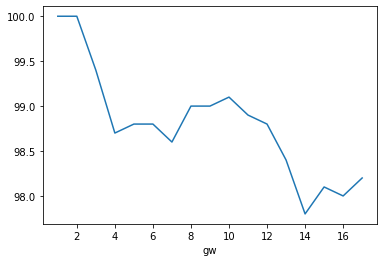

In [40]:
all_selections.groupby('gw')['value'].sum().plot()

In [41]:
np.round(all_selections[(all_selections['gw'] == 17)]['now_cost'].sum(), 1)

98.2

In [42]:
np.round(MONEY_IN_BANK, 1)

1.5

## TODO: 
- Investigate why GW 18 (<10 fixtures) fails

- Keep track of excess transfers

- If player does not start don't make transfer (is number of low value players maintained throughout?)

- Make free hit select 3 low value to maximise starting 11 score

- Select best permutation based on total of starting 11 not whole team

Note:

- Looks like forcing 2 low value players into team leads to lower point overall